# Dogs vs. cats image classification: Inception V3

In [1]:
# Handle imports up-front
import os
import sys
import glob
import pickle
from pathlib import Path
from functools import partial

# Silence logging messages from TensorFlow, except errors
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

# Use a specific GPU, if desired
os.environ['CUDA_VISIBLE_DEVICES']='2'

# PyPI imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications import inception_v3
from keras.models import Model
from keras import layers #import Input, RandomFlip, RandomZoom, RandomRotation, Dense, GlobalAveragePooling2D, Dropout
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Import SDG optimizer correctly based on the TensorFlow version
tf_version=float('.'.join(tf.__version__.split('.')[0:2]))

if tf_version > 2.8:
    from keras.optimizers import SGD
    sgd=SGD(learning_rate=0.00005, momentum=0.9)

else:
    from keras.optimizers import gradient_descent_v2
    sgd=gradient_descent_v2.SGD(learning_rate=0.00005, momentum=0.9)

# Figure out if we are running on Kaggle or not, then do some path stuff
# based on the answer
path_list=os.getcwd().split(os.sep)

if path_list[1] == 'kaggle':
    sys.path.append('/kaggle/usr/lib/image_classification_functions')
    model_path='/kaggle/working/models'

else:
    model_path='../data/models'

# Import custom helper functions from utils.py
from image_classification_functions import prep_data
from image_classification_functions import plot_single_training_run

# Silence logging messages from TensorFlow, except errors
tf.get_logger().setLevel('ERROR')

# Limit TensorFlow's CPU usage
tf.config.threading.set_intra_op_parallelism_threads(2)
tf.config.threading.set_inter_op_parallelism_threads(2)

In [2]:
tune_output=False
tune_inception_block=True

Path(model_path).mkdir(parents=True, exist_ok=True)
output_tuned_savefile=f'{model_path}/inceptionV3_output_tuned.pkl'
inception_tuned_savefile=f'{model_path}/inceptionV3_tuned.pkl'

## 1. Data preparation

### 1.1. Load the data paths

In [3]:
# Decompress and organize the images
training_data_path, validation_data_path, testing_data_path=prep_data()

# Get lists of training and validation dog and cat images
training_dogs=glob.glob(f'{training_data_path}/dogs/dog.*')
training_cats=glob.glob(f'{training_data_path}/cats/cat.*')
validation_dogs=glob.glob(f'{validation_data_path}/dogs/dog.*')
validation_cats=glob.glob(f'{validation_data_path}/cats/cat.*')

Not running in Kaggle notebook
Checking data prep
Data prep already complete


### 1.2. Create training and validation datasets

In [4]:
training_dataset=tf.keras.utils.image_dataset_from_directory(
    training_data_path,
    image_size=(128, int(128*(3/4))),
    batch_size=256
)

validation_dataset=tf.keras.utils.image_dataset_from_directory(
    validation_data_path,
    image_size=(128, int(128*(3/4))),
    batch_size=256
)

### 1.3. Create testing dataset

In [5]:
testing_dataset=tf.keras.utils.image_dataset_from_directory(
    testing_data_path,
    image_size=(128, int(128*(3/4)))
)

## 2. Model fine-tuning
### 2.1. Train output layers

In [ ]:
%%time

if tune_output == True:

    # Define a preprocessing model
    preprocessing_input=layers.Input(shape=(128,96,3))
    x=layers.RandomFlip('horizontal')(preprocessing_input)
    x=layers.RandomRotation(0.1)(x)
    x=layers.RandomZoom(0.1)(x)
    preprocessing_output=inception_v3.preprocess_input(x)
    preprocessing_model=Model(inputs=preprocessing_input, outputs=preprocessing_output)

    # Create the base pre-trained model
    base_model=inception_v3.InceptionV3(weights='imagenet', input_shape=(128,96,3), include_top=False)

    # Train only the output layers by freezing all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add some output layers
    x=base_model.output
    x=layers.GlobalAveragePooling2D()(x)
    x=layers.Dropout(0.2)(x)
    x=layers.Dense(128,activation='relu')(x)
    predictions=layers.Dense(1, activation='sigmoid')(x)

    # Define the inception v3 model with the added output layers
    inception_model=Model(inputs=base_model.input, outputs=predictions)

    # Define the combined model
    model_input=layers.Input(shape=(128, 96, 3))
    preprocessing_output=preprocessing_model(model_input)
    inception_output=inception_model(preprocessing_output)
    model=Model(inputs=model_input, outputs=inception_output)

    # Compile the model to train on binary cross-entropy loss
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy'])

    # Train the model on the new data for a few epochs
    training_result=model.fit(
        training_dataset,
        validation_data=validation_dataset,
        epochs=30
    )

    # Save the results
    with open(output_tuned_savefile, 'wb') as output_file:
        pickle.dump(training_result, output_file, protocol=pickle.HIGHEST_PROTOCOL)

else:
    with open(output_tuned_savefile, 'rb') as output_file:
        training_result=pickle.load(output_file)

print()


CPU times: user 21.3 s, sys: 544 ms, total: 21.9 s
Wall time: 21.9 s


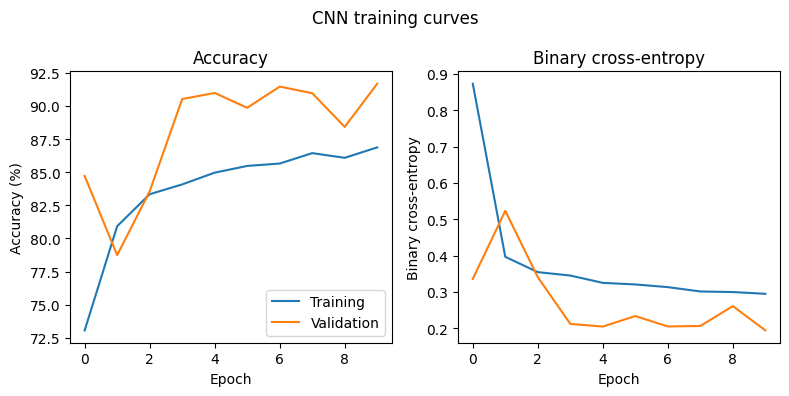

In [7]:
# Plot the results
plot_single_training_run(training_result).show()

### 2.2. Train inception layers

In [ ]:
%%time

if tune_inception_block is True:

    # Train the top 2 inception blocks, by freezing the first 249 layers
    # of the inception model layer in the combined model
    for layer in training_result.model.layers[2].layers[:249]:
        layer.trainable=False
    for layer in training_result.model.layers[2].layers[249:]:
        layer.trainable=True

    # Recompile the model using SGD with a low learning rate
    training_result.model.compile(
        optimizer=sgd,
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )

    # Train again
    training_result=training_result.model.fit(
        training_dataset,
        validation_data=validation_dataset,
        epochs=100
    )

    # Save the results
    with open(inception_tuned_savefile, 'wb') as output_file:
        pickle.dump(training_result, output_file, protocol=pickle.HIGHEST_PROTOCOL)

else:
    with open(inception_tuned_savefile, 'rb') as output_file:
        training_result=pickle.load(output_file)

print()

Epoch 1/100
59/59 [==============================] - 43s 525ms/step - loss: 0.4835 - binary_accuracy: 0.7805 - val_loss: 0.2313 - val_binary_accuracy: 0.9092
Epoch 2/100
59/59 [==============================] - 25s 414ms/step - loss: 0.4627 - binary_accuracy: 0.8028 - val_loss: 0.2740 - val_binary_accuracy: 0.9002
Epoch 3/100
59/59 [==============================] - 25s 415ms/step - loss: 0.4436 - binary_accuracy: 0.8164 - val_loss: 0.3021 - val_binary_accuracy: 0.8900
Epoch 4/100
59/59 [==============================] - 25s 420ms/step - loss: 0.4232 - binary_accuracy: 0.8244 - val_loss: 0.3141 - val_binary_accuracy: 0.8884
Epoch 5/100
59/59 [==============================] - 25s 421ms/step - loss: 0.4098 - binary_accuracy: 0.8319 - val_loss: 0.3130 - val_binary_accuracy: 0.8886
Epoch 6/100
59/59 [==============================] - 25s 422ms/step - loss: 0.3971 - binary_accuracy: 0.8338 - val_loss: 0.3061 - val_binary_accuracy: 0.8916
Epoch 7/100
59/59 [==============================] -

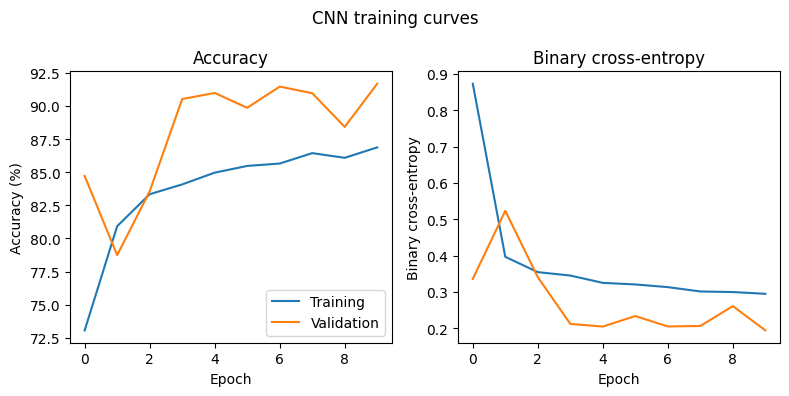

In [9]:
# Plot the results
plot_single_training_run(training_result).show()

## 3. Model evaluation

### 3.2. Make predictions

In [10]:
images=np.concatenate([x for x, y in validation_dataset], axis=0)
labels=np.concatenate([y for x, y in validation_dataset], axis=0)

predictions=training_result.model.predict(images)
print(f'Testing images shape: {images.shape}')
print(f'Testing labels shape: {labels.shape}')

threshold=0.5
predictions=[1 if p > threshold else 0 for p in predictions]

accuracy=accuracy_score(predictions, labels)*100
print(f'Test set accuracy: {accuracy:.1f}%')

Testing images shape: (5000, 128, 96, 3)
Testing labels shape: (5000,)
Test set accuracy: 50.2%


### 3.3. Model performance

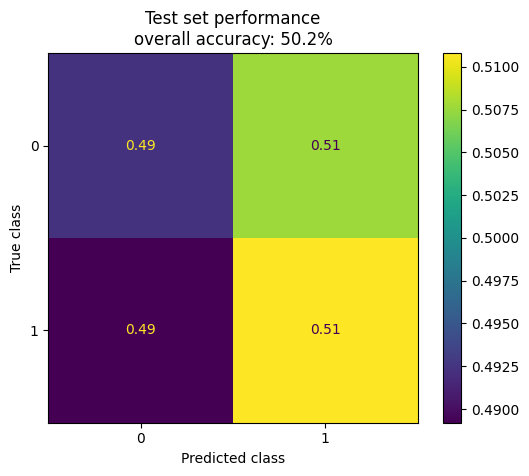

In [11]:
# Plot the confusion matrix
cm=confusion_matrix(labels, predictions, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
_=cm_disp.plot()

plt.title(f'Test set performance\noverall accuracy: {accuracy:.1f}%')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()